In [1]:
mat_version = 1169

import os
import sys
from os.path import join as pjoin

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# # NOTE: adjust for your system
# data_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/data/{mat_version}"
# utils_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/code/utils"

# # NOTE: adjust for your system
data_dir = pjoin('..','..','data', f"v1dd_{mat_version}")
utils_dir = pjoin("..","utils")

sys.path.append(utils_dir)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Import packages </h2>
   
<b> The CAVEclient</b> is a python library that facilitates communication with a CAVE system. For convenience, we also use the package <b>skeleton_plot</b> which handles rendering the precomputed skeletons. 
   
</div>

In [2]:
# Import packages
from caveclient import CAVEclient
import skeleton_plot as skelplot
from matrix_plotting import adjacencyplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Define utility functions </h2>

</div>

In [3]:
def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


In [4]:
def check_index(
    index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
) -> pd.Index:
    if isinstance(index, (pd.DataFrame, pd.Series)):
        index = index.index
    elif isinstance(index, (np.ndarray, list)):
        index = pd.Index(index)
    else:
        raise TypeError(
            f"Index has to be of type pd.DataFrame, pd.Series, np.ndarray or list; got {type(index)}"
        )
    return index


def make_adjacency(
    synapses,
    source_cell_index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
    target_cell_index: Optional[
        Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list]
    ] = None,
    aggfunc="binary",
) -> csr_array:
    source_cell_index = check_index(source_cell_index)
    if target_cell_index is None:
        target_cell_index = source_cell_index
    else:
        target_cell_index = check_index(target_cell_index)
    synapses = synapses.query(
        "pre_pt_root_id in @source_cell_index and post_pt_root_id in @target_cell_index"
    )
    groupby = synapses.groupby(["pre_pt_root_id", "post_pt_root_id"])
    if aggfunc == "count":
        edges = groupby.size().rename("weight").reset_index()
    elif aggfunc == "binary":
        edges = groupby.size().transform(lambda x: x > 0).rename("weight").reset_index()
    else:
        edges = groupby["size"].agg(aggfunc).rename("weight").reset_index()
    # make sure that the adjacency matrix is sorted the same as the input cell index
    edges["source_index"] = source_cell_index.get_indexer(edges["pre_pt_root_id"])
    edges["target_index"] = target_cell_index.get_indexer(edges["post_pt_root_id"])
    adjacency = csr_array(
        (edges["weight"], (edges["source_index"], edges["target_index"])),
        shape=(len(source_cell_index), len(target_cell_index)),
        dtype=edges["weight"].dtype,
    )
    return adjacency

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Exercise 1.1: Connection specificity onto compartment types
For the main workshop we considered all synapses between any two cells, but different synapses target different compartments on the post synaptic cell. 

A textbook example is the <b>basket cell</b> which often targets the soma of neurons, whereas other inhibitory cells often target the shaft of other cells. 

In this exercise you will test if:
<ol>
    <li>you can separate two classes of inhibitory neurons by: those that target the soma of cells and those do not</li>
    <li>can you separate excitatory cells from inhibitory cells by their 'spinyness' </li>
    <li>does the number of synapses vary among different cell-type connections?</li>
</ol>

<font size=4> For this you will need to load in data about the target compartment of the synapse, one of: spine, shaft, soma </font>
    
</d>

In [5]:
# Load the synapse table
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
).set_index('id')

# Now load the table that includes the target structure and combine to your synapse matrix
target_structure = pd.read_feather(
    pjoin(data_dir, f"syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
)['tag']
target_structure

# Combine the target information to the proofread synapses table
syn_df["target_structure"] = target_structure
syn_df["target_structure"] = syn_df["target_structure"].fillna("unknown")
print(syn_df["target_structure"].value_counts())
syn_df.head()

target_structure
shaft      3826685
spine      2685884
unknown    1489677
soma        187829
Name: count, dtype: int64


,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure
id,,,,,,,,,,,,,
354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,shaft
220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,unknown
119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,unknown
378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,shaft
560121937,1054031.1,711388.3,323010.0,1054234.8,711417.4,323100.0,1054147.5,711368.9,323010.0,440,864691132558474249,864691132640932240,shaft


In [7]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]
# Load the cell type table
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

# Filter the proofread ids for those with a known cell type
proof_root_ids = np.intersect1d(proof_root_ids, cell_df["pt_root_id"].values)

# Filter the cell type table for those with a proofread root id
proof_cell_df = cell_df.set_index("pt_root_id").loc[proof_root_ids]
proof_cell_df = proof_cell_df.query("cell_type.notna()")

# Make adjacency, now including soma depth and cell type
syn_mat = make_adjacency(syn_df, proof_cell_df, aggfunc="sum")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Select soma-tageting synapses only

</div>

In [9]:
# Filter the synapse table by compartment type is only 'soma'
soma_syns = syn_df.query(f"target_structure == '{'soma'}'")
soma_syn_mat = make_adjacency(
    soma_syns, source_cell_index=proof_cell_df
)

In [10]:
# Create a color pallete based on cell type and class
node_hue = "cell_type"

n_e_classes = len(proof_cell_df.query("cell_type_coarse == 'E'")[node_hue].unique())
n_i_classes = len(proof_cell_df.query("cell_type_coarse == 'I'")[node_hue].unique())

e_colors = sns.cubehelix_palette(
    start=0.4, rot=0.3, light=0.85, hue=1.0, dark=0.4, gamma=1.3, n_colors=n_e_classes
)

i_colors = sns.cubehelix_palette(
    start=0.3, rot=-0.4, light=0.75, dark=0.2, hue=1.0, gamma=1.3, n_colors=n_i_classes
)

cell_type_palette = dict(
    zip(
        proof_cell_df.sort_values(["cell_type_coarse", node_hue])[node_hue].unique(),
        e_colors + i_colors,
    )
)

cell_type_palette["E"] = np.array(list(e_colors)).mean(axis=0)
cell_type_palette["I"] = np.array(list(i_colors)).mean(axis=0)

(<Axes: >, <matrix_plotting.AxisGrid at 0x1aa5d34eb10>)

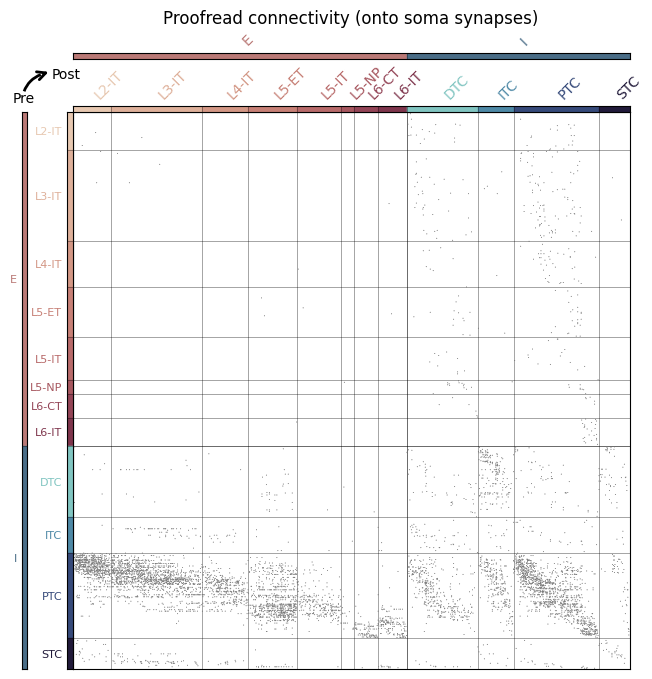

In [11]:
# Set the adjacency plot arguments 
adjplot_kws = dict(
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.5, 5),  # set the min and max size of the dots
    hue_norm=(-1, 1),  # set how to scale colors
)

# render the adjacency plot
adjacencyplot(
    soma_syn_mat, # data values for the points
    nodes=proof_cell_df, # data to organize the x and y axis
    groupby=["cell_type_coarse", "cell_type"], # categorical variables to organize by
    sortby="pt_position_y", # sort within groups by variable
    node_palette=cell_type_palette,
    title="Proofread connectivity (onto soma synapses)",
    **adjplot_kws,
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Select spine-tageting synapses only

</div>

In [12]:
# Filter the synapse table by compartment type is only 'soma'
spine_syns = syn_df.query(f"target_structure == '{'spine'}'")
spine_syn_mat = make_adjacency(
    spine_syns, source_cell_index=proof_cell_df
)

In [13]:
# Create a color pallete based on cell type and class
node_hue = "cell_type"

n_e_classes = len(proof_cell_df.query("cell_type_coarse == 'E'")[node_hue].unique())
n_i_classes = len(proof_cell_df.query("cell_type_coarse == 'I'")[node_hue].unique())

e_colors = sns.cubehelix_palette(
    start=0.4, rot=0.3, light=0.85, hue=1.0, dark=0.4, gamma=1.3, n_colors=n_e_classes
)

i_colors = sns.cubehelix_palette(
    start=0.3, rot=-0.4, light=0.75, dark=0.2, hue=1.0, gamma=1.3, n_colors=n_i_classes
)

cell_type_palette = dict(
    zip(
        proof_cell_df.sort_values(["cell_type_coarse", node_hue])[node_hue].unique(),
        e_colors + i_colors,
    )
)

cell_type_palette["E"] = np.array(list(e_colors)).mean(axis=0)
cell_type_palette["I"] = np.array(list(i_colors)).mean(axis=0)

(<Axes: >, <matrix_plotting.AxisGrid at 0x1aa5d8679d0>)

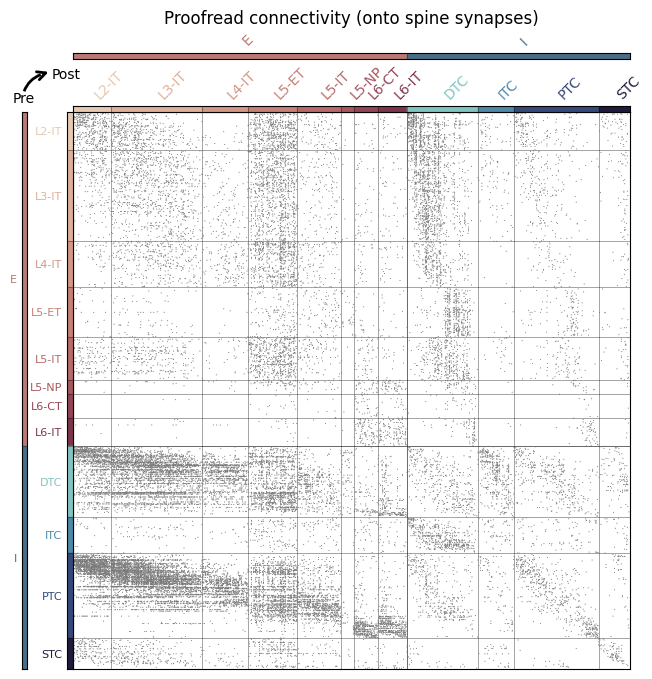

In [14]:
# Set the adjacency plot arguments 
adjplot_kws = dict(
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.5, 5),  # set the min and max size of the dots
    hue_norm=(-1, 1),  # set how to scale colors
)

# render the adjacency plot
adjacencyplot(
    spine_syn_mat, # data values for the points
    nodes=proof_cell_df, # data to organize the x and y axis
    groupby=["cell_type_coarse", "cell_type"], # categorical variables to organize by
    sortby="pt_position_y", # sort within groups by variable
    node_palette=cell_type_palette,
    title="Proofread connectivity (onto spine synapses)",
    **adjplot_kws,
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Plot synapse number instead of sum size

</div>

In [16]:
# Make adjacency on counts not num
syn_mat = make_adjacency(syn_df, proof_cell_df, aggfunc="count")

In [17]:
# Create a color pallete based on cell type and class
node_hue = "cell_type"

n_e_classes = len(proof_cell_df.query("cell_type_coarse == 'E'")[node_hue].unique())
n_i_classes = len(proof_cell_df.query("cell_type_coarse == 'I'")[node_hue].unique())

e_colors = sns.cubehelix_palette(
    start=0.4, rot=0.3, light=0.85, hue=1.0, dark=0.4, gamma=1.3, n_colors=n_e_classes
)

i_colors = sns.cubehelix_palette(
    start=0.3, rot=-0.4, light=0.75, dark=0.2, hue=1.0, gamma=1.3, n_colors=n_i_classes
)

cell_type_palette = dict(
    zip(
        proof_cell_df.sort_values(["cell_type_coarse", node_hue])[node_hue].unique(),
        e_colors + i_colors,
    )
)

cell_type_palette["E"] = np.array(list(e_colors)).mean(axis=0)
cell_type_palette["I"] = np.array(list(i_colors)).mean(axis=0)

(<Axes: >, <matrix_plotting.AxisGrid at 0x1aa8bcdbc10>)

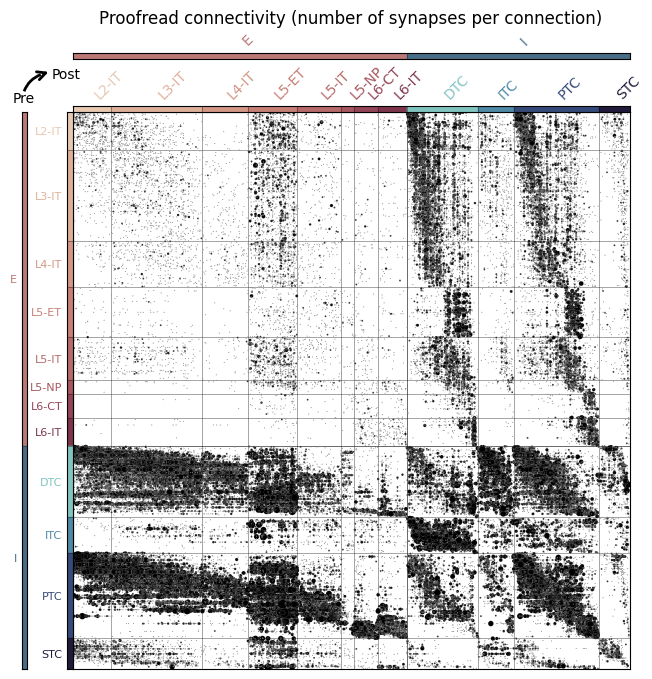

In [24]:
# Set the adjacency plot arguments 
adjplot_kws = dict(
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.5, 50),  # set the min and max size of the dots
    hue_norm=(-1,1),  # set how to scale colors
)

# render the adjacency plot
adjacencyplot(
    syn_mat, # data values for the points
    nodes=proof_cell_df, # data to organize the x and y axis
    groupby=["cell_type_coarse", "cell_type"], # categorical variables to organize by
    sortby="pt_position_y", # sort within groups by variable
    node_palette=cell_type_palette,
    title="Proofread connectivity (number of synapses per connection)",
    **adjplot_kws,
)

## Exercise 1.2 Summarize output distributions

## Exercise 1.3 Plot targets of individual inhibitory cells in ‘post synaptic cell coordinates’
Look at a basket cells versus a chandelier cell, versus a SST cell

In [ ]:
## Keep for solutions
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

categories = ["spine", "shaft", "soma"]

for i, category in enumerate(categories):
    ax = axs[i]
    category_syns_df = proof_syns.query(f"target_structure == '{category}'")
    category_syn_mat = make_adjacency(
        category_syns_df, source_cell_index=proof_cell_df
    )
    ax, grid = adjacencyplot(
        category_syn_mat,
        nodes=proof_cell_df,
        groupby=["cell_type_coarse", "cell_type"],
        sortby="pt_position_y",
        node_palette=cell_type_palette,
        title=category.capitalize(),
        edge_hue=True,
        edge_size=True,
        edge_palette="Greys",
        sizes=(0.5, 1),  # set the min and max size of the dots
        hue_norm=(-1, 1),  # set how to scale colors
        edge_linewidth=0,
        ax=ax,
        arc_labels=False,
    )
